In [66]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from copy import deepcopy
from statsmodels.graphics.gofplots import qqplot
from statsmodels.formula.api import ols
from scipy.stats import levene
from scipy.stats import skew
from warnings import filterwarnings
filterwarnings(action = 'ignore')
%matplotlib inline

In [3]:
raw = pd.read_csv('Data.csv', usecols=['Service Level', 'Weight'])
df = deepcopy(raw)

In [4]:
df.sample(4)

,Service Level,Weight
4462,DTP,3.277111
8418,DTD,6.720000
1764,DTP,0.398015
2351,DTP,7.941991


#### We'll conduct ANOVA for this, but first some EDA and assumptions

In [8]:
#Differences between mean and median
table = pd.pivot_table(data=df, index='Service Level', aggfunc=[np.mean, np.median, np.var, 'count'])
table

,mean,median,var,count
,Weight,Weight,Weight,Weight
Service Level,,,,
CRF,41.103810,5.970014,12347.530301,854
DTD,12.946981,5.547865,588.523361,2143
DTP,19.342162,4.096388,4592.044469,6218


In [6]:
def check_gaussian_visual(data, cat_col:str, con_col:str):
    for cat in data[cat_col].unique():
        fig = qqplot(data[data[cat_col]==cat][con_col], line = '45', fit=True)
        ax = plt.gca()
        fig.set_size_inches(15, 8)
        ax.set_xlabel('Theoretical Quantiles', fontsize=13)
        ax.set_ylabel(f'Sample Quantiles of the {cat} category', fontsize=13)
        ax.set_title("QQ Plot of Categories", fontsize=16)
        plt.show()

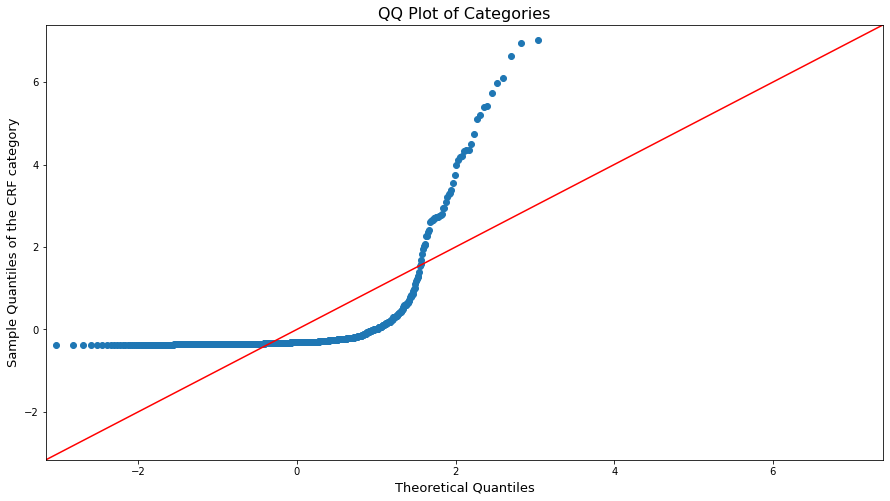

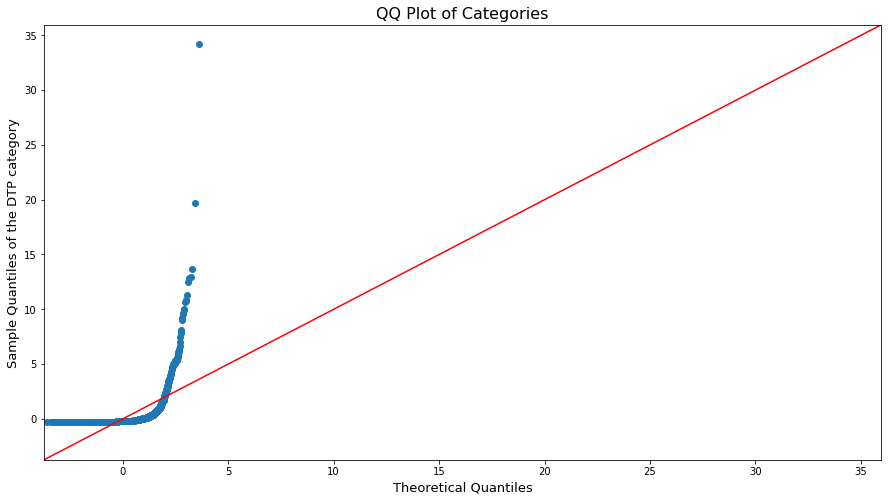

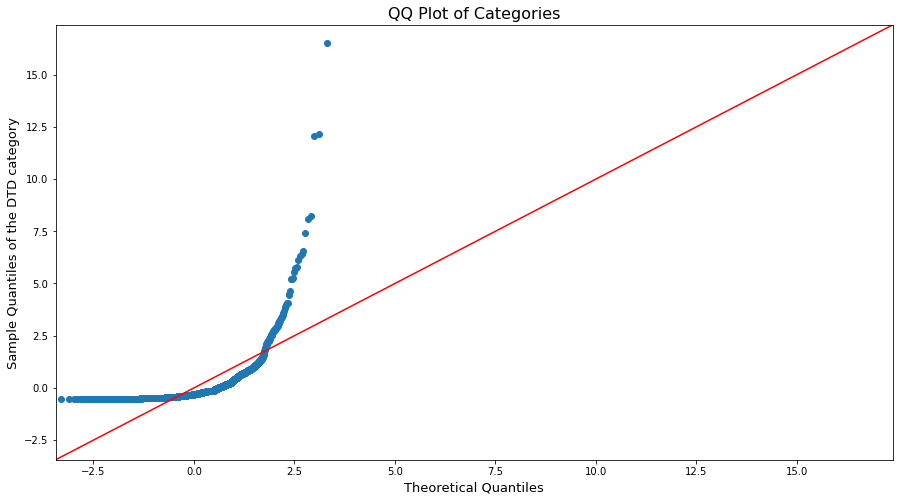

In [7]:
check_gaussian_visual(df, 'Service Level', 'Weight')

In [9]:
table_0 = df.loc[df['Service Level']=='CRF']
table_1 = df.loc[df['Service Level']=='DTD']
table_2 = df.loc[df['Service Level']=='DTP']

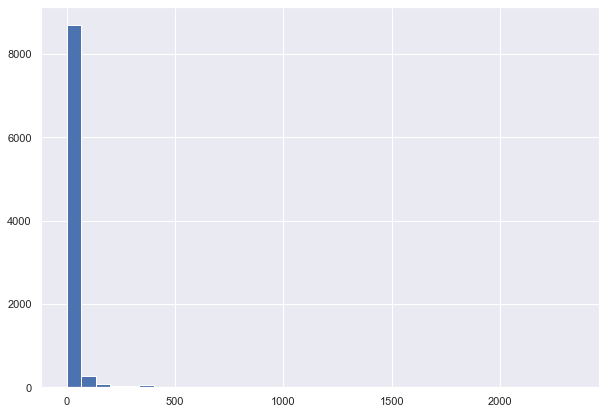

In [21]:
sns.set(rc={'figure.figsize':(10,7)})
plt.hist('Weight', data=df, bins=35)
plt.show()

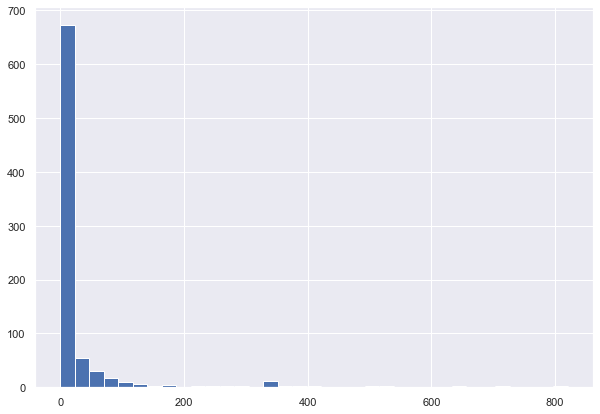

In [17]:
plt.hist('Weight', data=table_0, bins=35)
plt.show()

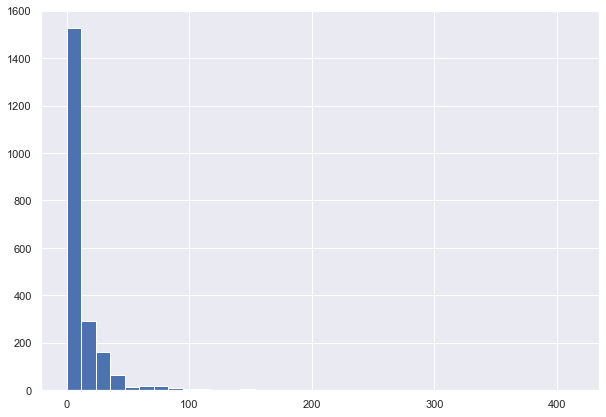

In [64]:
plt.hist('Weight', data=table_1, bins=35)
plt.show()

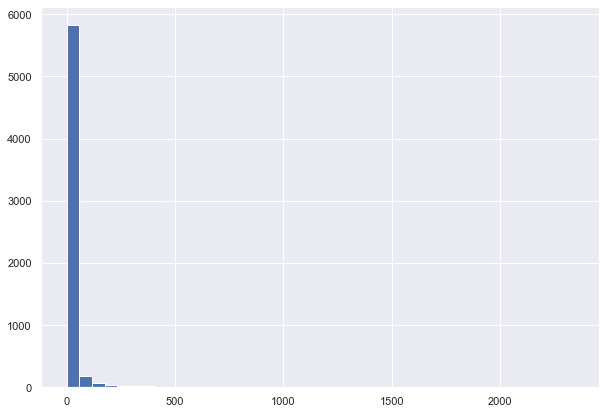

In [66]:
plt.hist('Weight', data=table_2, bins=40)
plt.show()

In [51]:
print(f'''Skewness of CRF category of weight: {skew(df[df['Service Level']=='CRF']['Weight'])}''')
print(f'''Skewness of DTD category of weight: {skew(df[df['Service Level']=='DTD']['Weight'])}''')
print(f'''Skewness of DTP category of weight: {skew(df[df['Service Level']=='DTP']['Weight'])}''')

Skewness of CRF category of weight: 4.1893215773185215
Skewness of DTD category of weight: 6.384039210938397
Skewness of DTP category of weight: 12.683031486967955


In [54]:
def find_outlier_records(data, column_name: str, no_std=3):
  assert (column_name in data.columns)
  no_outliers = 0 
  values = data[column_name].unique() 
  upper_border = np.asarray(data[column_name]).mean() + no_std*(np.asarray(data[column_name]).std())
  lower_border = np.asarray(data[column_name]).mean() - no_std*(np.asarray(data[column_name]).std()) 
  for value in values:
    if value>upper_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    elif value<lower_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    else:
      continue
  print(f'''Number of outlier records in {column_name} column: {no_outliers}''')

In [65]:
find_outlier_records(df[df['Service Level']=='CRF'], 'Weight')
find_outlier_records(df[df['Service Level']=='DTD'], 'Weight')
find_outlier_records(df[df['Service Level']=='DTP'], 'Weight')

Number of outlier records in Weight column: 26
Number of outlier records in Weight column: 39
Number of outlier records in Weight column: 106


In [31]:
def check_equal_variances(data, cat_col, con_col):
    homoscedasticity_test = levene(data[data[cat_col]=='CRF'][con_col], data[data[cat_col]=='DTD'][con_col],
                              data[data[cat_col]=='DTP'][con_col])
    print(f'''Levene's test p-value: {homoscedasticity_test.pvalue}''')

In [32]:
#Null hypothesis couldn't be rejected
check_equal_variances(df, 'Service Level', 'Weight') 

Levene's test p-value: 1.1770027873331043e-24


#### Although the Levene's test concluded homogenity in variances, the samples are highly skewed and we've got numerous outliers, so ANOVA isn't the most powerful test at this point. So, we'll go with non-parametric Kruskal-Wallis H Test and compare the medians.

In [82]:
from scipy import stats
stats.kruskal(df[df['Service Level']=='CRF']['Weight'], 
              df[df['Service Level']=='DTD']['Weight'], 
              df[df['Service Level']=='DTP']['Weight']).pvalue

1.3871386650136796e-18

In [33]:
#p-value of 1.38 meaning the medians of weights are not statistically different  